<a href="https://colab.research.google.com/github/Nabin15/Project/blob/main/Final_Project_LR%26SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intent Classification in Customer Support using Banking77 Dataset
This notebook compares traditional ML and deep learning models.

In [26]:
# Libraries for Logistic regression & svm

import pandas as pd
import gc, pickle, numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, accuracy_score, f1_score, log_loss, hinge_loss, confusion_matrix
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, LSTM, GlobalMaxPooling1D, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from matplotlib.ticker import MaxNLocator
from time import perf_counter
import torch
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from collections import Counter
import re, unicodedata

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# CodeGrade Tag Init1
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Load Dataset

In [3]:
# dataset loading
train_df = pd.read_csv('/content/drive/MyDrive/Project_Intent/banking77_train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/Project_Intent/banking77_test.csv')

## EDA

In [4]:
# Three Random Rows From Train Dataset
df_all = pd.concat([train_df, test_df], axis=0, ignore_index=True)
df_all.sample(3)

,text,category
12091,Please explain to me the circumstances in whic...,reverted_card_payment?
4918,Can someone help with my passcode?,passcode_forgotten
1950,My top-up is taking a while to process!,pending_top_up


In [5]:
# Checking some basic information
print("Train shape:", train_df.shape)
print("Test shape :", test_df.shape)
print("Columns    :", list(df_all.columns))

print("\n=== Missing values by column ===")
print(df_all[['text','category']].isna().sum())

print("\n=== Duplicate rows (exact text+category) ===")
dups_both = df_all.duplicated(subset=['text','category']).sum()
print("Exact duplicates (text+category):", dups_both)

print("\n=== Potential label conflicts (same text, different label) ===")
conflicts = (df_all.groupby('text')['category']
             .nunique().reset_index(name='n_labels'))
conflicts = conflicts[conflicts['n_labels'] > 1]
print("Conflicting texts:", len(conflicts))

Train shape: (10003, 2)
Test shape : (3080, 2)
Columns    : ['text', 'category']

=== Missing values by column ===
text        0
category    0
dtype: int64

=== Duplicate rows (exact text+category) ===
Exact duplicates (text+category): 0

=== Potential label conflicts (same text, different label) ===
Conflicting texts: 0


In [6]:
# Checking Classes Details of train dataset
cnt = train_df['category'].value_counts()
imbalance_ratio = cnt.max() / cnt.min()         # 1.0 = perfectly balanced
cv = cnt.std() / cnt.mean()                     # coefficient of variation
print(f"Classes: {len(cnt)}")
print(f"Min/Max: {cnt.min()} / {cnt.max()}")
print(f"Imbalance ratio (max/min): {imbalance_ratio:.2f}")
print(f"CV (std/mean): {cv:.3f}")

Classes: 77
Min/Max: 35 / 187
Imbalance ratio (max/min): 5.34
CV (std/mean): 0.254


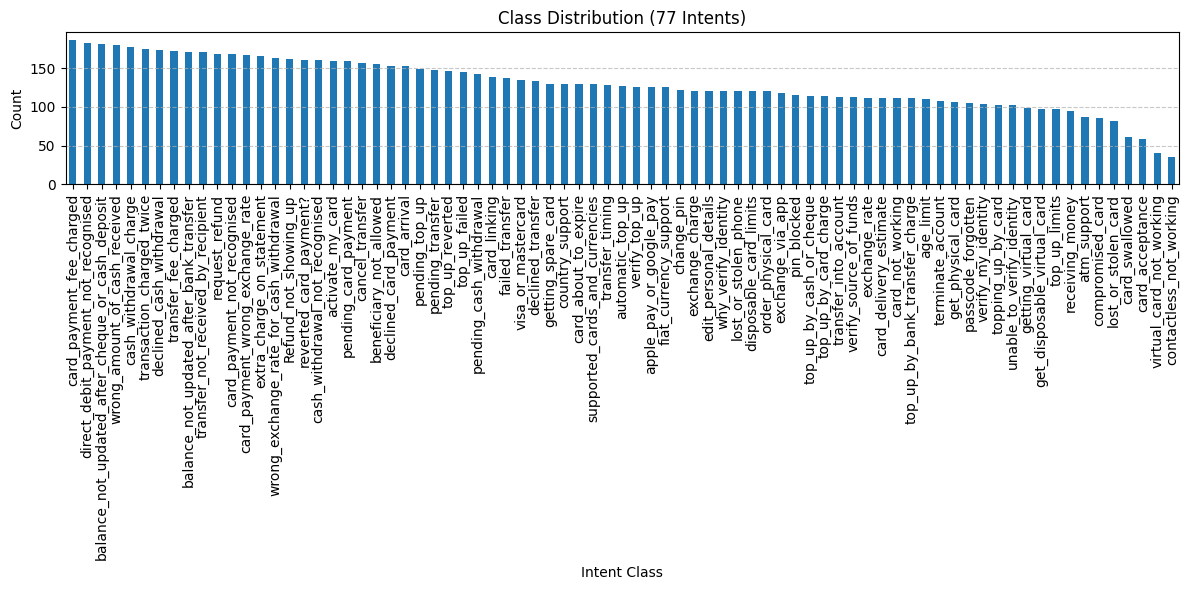

Top 5 classes:
 category
card_payment_fee_charged                            187
direct_debit_payment_not_recognised                 182
balance_not_updated_after_cheque_or_cash_deposit    181
wrong_amount_of_cash_received                       180
cash_withdrawal_charge                              177
Name: count, dtype: int64

Bottom 5 classes:
 category
lost_or_stolen_card         82
card_swallowed              61
card_acceptance             59
virtual_card_not_working    41
contactless_not_working     35
Name: count, dtype: int64


In [7]:
# Plot Class Distribution of train dataset
plt.figure(figsize=(12,6))
train_df['category'].value_counts().plot(kind='bar')
plt.title('Class Distribution (77 Intents)')
plt.xlabel('Intent Class')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('class_distribution.png')
plt.show()

# Print imbalance stats
print("Top 5 classes:\n", train_df['category'].value_counts().head())
print("\nBottom 5 classes:\n", train_df['category'].value_counts().tail())

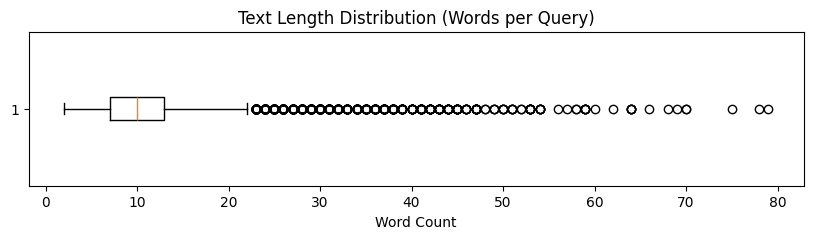

Median length: 10.0 words
Q1 : 7.0 words
Q3 : 13.0 words
Max length: 79 words
Min length: 2 words


In [8]:
# Add Text Length Column of train dataset
train_df['text_length'] = train_df['text'].apply(lambda x: len(x.split()))

# Plot distribution
plt.figure(figsize=(10,2))
plt.boxplot(train_df['text_length'], vert=False)
plt.title('Text Length Distribution (Words per Query)')
plt.xlabel('Word Count')
plt.savefig('text_length_distribution.png')
plt.show()

# Print stats
print(f"Median length: {train_df['text_length'].median()} words")
print(f"Q1 : {train_df['text_length'].quantile(0.25)} words")
print(f"Q3 : {train_df['text_length'].quantile(0.75)} words")
print(f"Max length: {train_df['text_length'].max()} words")
print(f"Min length: {train_df['text_length'].min()} words")

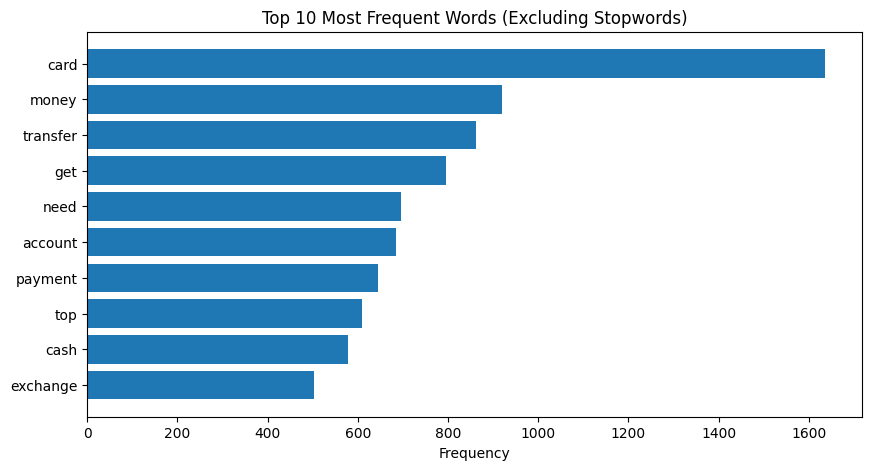

In [9]:
# Tokenize and count words (excluding stopwords) of train dataset
all_words = ' '.join(train_df['text']).split()
stop_words = set(stopwords.words('english'))
filtered_words = [word.lower() for word in all_words if word.lower() not in stop_words and word.isalpha()]

# Plot top 10
word_counts = Counter(filtered_words).most_common(10)
plt.figure(figsize=(10,5))
plt.barh([w[0] for w in word_counts], [w[1] for w in word_counts])
plt.title('Top 10 Most Frequent Words (Excluding Stopwords)')
plt.xlabel('Frequency')
plt.gca().invert_yaxis()  # Highest frequency on top
plt.savefig('top_10_words.png')
plt.show()

## Preprocessing

In [10]:
# Cleaning text from both train & test dataset
# Define the cleaning function
def clean_text(s: str) -> str:
    if pd.isna(s):
        return ""

    # 1. Normalize Unicode characters (standardize quotes, spaces, etc.)
    s = unicodedata.normalize("NFKC", str(s))

    # 2. Replace smart quotes, fancy dashes, and ellipsis with plain forms
    s = (s.replace("’", "'").replace("‘", "'").replace("“", '"').replace("”", '"')
           .replace("–", "-").replace("—", "-").replace("…", "..."))

    # 3. Map currency symbols to words
    s = s.replace("£", " gbp ").replace("€", " eur ").replace("$", " usd ")

    # 4. Lowercase everything
    s = s.lower()

    # 5. Replace URLs with placeholder
    s = re.sub(r"(https?://\S+|www\.\S+)", " <url> ", s)

    # 6. Replace emails with placeholder
    s = re.sub(r"\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Za-z]{2,}\b", " <email> ", s)

    # 7. Collapse multiple spaces into one and trim
    s = re.sub(r"\s+", " ", s).strip()

    return s

# Apply cleaning to both datasets
train_df["clean_text"] = train_df["text"].apply(clean_text)
test_df["clean_text"] = test_df["text"].apply(clean_text)

In [11]:
# Label Encoding
le = LabelEncoder()
train_df['label'] = le.fit_transform(train_df['category'])
test_df['label'] = le.transform(test_df['category'])

In [12]:
# Checking bottom10 label Encoded class on queries
n_classes = len(le.classes_)
counts = np.bincount(train_df["label"], minlength=n_classes)

mapping = pd.DataFrame({"label_id": np.arange(n_classes),"category": le.classes_,"train_count": counts}).sort_values("label_id")

bottom10 = mapping.sort_values("train_count", ascending=True).head(10)
print(f"Number of classes: {n_classes}")
print(bottom10.to_string(index=False))

Number of classes: 77
 label_id                    category  train_count
       24     contactless_not_working           35
       72    virtual_card_not_working           41
       11             card_acceptance           59
       19              card_swallowed           61
       42         lost_or_stolen_card           82
       23            compromised_card           86
        4                 atm_support           87
       51             receiving_money           95
       38 get_disposable_virtual_card           97
       60               top_up_limits           97


In [14]:
# Convert training and validation text data into numerical feature vectors using TF-IDF for logistic regression & svm

tfidf = TfidfVectorizer(max_features=5000)  # top 5000 most frequent terms
X_train_tfidf = tfidf.fit_transform(X_train)  # Learn vocabulary and transform training data
X_val_tfidf = tfidf.transform(X_val)  # Transform validation data using the same vocabulary
X_test_tfidf = tfidf.transform(X_test)  # Transform test data using the same vocabulary

In [15]:
# A) Features: word n-grams + character n-grams
from scipy.sparse import hstack
from sklearn.feature_extraction.text import TfidfVectorizer

# Word n-grams: capture phrases like "reset pin"
word_vec = TfidfVectorizer(ngram_range=(1,3),
                           max_features=50000,
                           min_df=2,
                           sublinear_tf=True,
                           lowercase=True)

# Char n-grams: robust for very short texts & misspellings
char_vec = TfidfVectorizer(analyzer="char",
                           ngram_range=(3,5),
                           min_df=2,
                           sublinear_tf=True,
                           lowercase=True)

X_train_word = word_vec.fit_transform(X_train)
X_val_word   = word_vec.transform(X_val)
X_test_word  = word_vec.transform(X_test)

X_train_char = char_vec.fit_transform(X_train)
X_val_char   = char_vec.transform(X_val)
X_test_char  = char_vec.transform(X_test)

X_train_mix = hstack([X_train_word, X_train_char]).tocsr()
X_val_mix   = hstack([X_val_word,   X_val_char]).tocsr()
X_test_mix  = hstack([X_test_word,  X_test_char]).tocsr()


## Model 1: Logistic Regression + TF-IDF

In [16]:
# Logistic Regression
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train_tfidf, y_train)

# Test predictions
y_test_pred = logreg.predict(X_test_tfidf)

# Summary table (Test only)
summary = pd.DataFrame(
    {"Test": [accuracy_score(y_test, y_test_pred),
            f1_score(y_test, y_test_pred, average="macro"),],},
    index=["Accuracy", "Macro F1"],)

print("\nLogistic Regression — Test Results")
print(summary.to_string(float_format=lambda x: f"{x:.4f}"))

# Detailed test report
print("\nTest classification report:")
print(classification_report(y_test, y_test_pred, digits=4))



Logistic Regression — Test Results
           Test
Accuracy 0.8682
Macro F1 0.8675

Test classification report:
              precision    recall  f1-score   support

           0     0.8333    0.8750    0.8537        40
           1     0.9744    0.9500    0.9620        40
           2     0.9524    1.0000    0.9756        40
           3     0.9750    0.9750    0.9750        40
           4     0.9474    0.9000    0.9231        40
           5     1.0000    0.9000    0.9474        40
           6     0.6458    0.7750    0.7045        40
           7     0.8444    0.9500    0.8941        40
           8     0.9189    0.8500    0.8831        40
           9     0.9024    0.9250    0.9136        40
          10     0.9750    0.9750    0.9750        40
          11     0.9355    0.7250    0.8169        40
          12     0.7907    0.8500    0.8193        40
          13     0.7826    0.9000    0.8372        40
          14     0.9070    0.9750    0.9398        40
          15     0.618

In [19]:
# Logistic Regression (word + char n-grams)
log_unweighted = LogisticRegression(max_iter=2000,
                                    n_jobs=-1,
                                    solver="lbfgs",
                                    multi_class="auto")
log_unweighted.fit(X_train_mix, y_train)

y_test_pred_log_unweighted = log_unweighted.predict(X_test_mix)

print("[LogReg unweighted] Test Acc / F1(macro):",
      f"{accuracy_score(y_test, y_test_pred_log_unweighted):.4f}",
      f"{f1_score(y_test, y_test_pred_log_unweighted, average='macro'):.4f}")

# Detailed test report
print("\n[LogReg unweighted] Test Classification Report:")
print(classification_report(y_test, y_test_pred_log_unweighted, digits=4))

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[LogReg unweighted] Test Acc / F1(macro): 0.8886 0.8888

[LogReg unweighted] Test Classification Report:
              precision    recall  f1-score   support

           0     0.9737    0.9250    0.9487        40
           1     1.0000    0.9250    0.9610        40
           2     1.0000    1.0000    1.0000        40
           3     1.0000    1.0000    1.0000        40
           4     0.9250    0.9250    0.9250        40
           5     1.0000    0.9250    0.9610        40
           6     0.7234    0.8500    0.7816        40
           7     0.8636    0.9500    0.9048        40
           8     0.9722    0.8750    0.9211        40
           9     0.9744    0.9500    0.9620        40
          10     1.0000    0.9750    0.9873        40
          11     0.9412    0.8000    0.8649        40
          12     0.8537    0.8750    0.8642        40
          13     0.8605    0.9250    0.8916        40
          14     0.9286    0.9750    0.9512        40
          15     0.6316    0.9

In [20]:
# End-to-end timing + model size for Logistic Regression (word + char n-grams)
import time, os, tempfile, joblib, numpy as np, pandas as pd
from pathlib import Path
from scipy.sparse import hstack
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score

def summarize(x):
    x = np.asarray(x, dtype=float)
    return {
        "median": np.median(x),
        "mean":   float(x.mean()),
        "std":    float(x.std(ddof=0)),
        "p10":    float(np.percentile(x, 10)),
        "p90":    float(np.percentile(x, 90)),
    }

# Configure features to match your code
WORD_VEC_KW = dict(ngram_range=(1,3), max_features=50000, min_df=2, sublinear_tf=True, lowercase=True)
CHAR_VEC_KW = dict(analyzer="char", ngram_range=(3,5), min_df=2, sublinear_tf=True, lowercase=True)

# Logistic Regression config (same as yours)
LR_KW = dict(max_iter=2000, n_jobs=-1, solver="lbfgs", multi_class="auto")

N_RUNS = 8  # increase if you want tighter stats

train_times = []
test_times  = []
sizes_mb    = []
accs        = []
f1s         = []
lat_ms      = []
throughputs = []

for run in range(N_RUNS):
    # Fresh vectorizers and model each run
    word_vec = TfidfVectorizer(**WORD_VEC_KW)
    char_vec = TfidfVectorizer(**CHAR_VEC_KW)
    clf      = LogisticRegression(**LR_KW)

    # End-to-end TRAIN timing: fit vecs + transform TRAIN + fit model
    t0 = time.perf_counter()
    X_train_word = word_vec.fit_transform(X_train)
    X_train_char = char_vec.fit_transform(X_train)
    X_train_mix  = hstack([X_train_word, X_train_char]).tocsr()
    clf.fit(X_train_mix, y_train)
    t_train = time.perf_counter() - t0
    train_times.append(t_train)

    # End-to-end TEST timing: transform TEST + predict
    t1 = time.perf_counter()
    X_test_word = word_vec.transform(X_test)
    X_test_char = char_vec.transform(X_test)
    X_test_mix  = hstack([X_test_word, X_test_char]).tocsr()
    y_pred      = clf.predict(X_test_mix)
    t_test      = time.perf_counter() - t1
    test_times.append(t_test)

    # Metrics
    acc = accuracy_score(y_test, y_pred)
    mf1 = f1_score(y_test, y_pred, average="macro")
    accs.append(acc); f1s.append(mf1)

    # Per-sample latency and throughput
    n_test = X_test.shape[0] if hasattr(X_test, "__len__") else X_test_mix.shape[0]
    lat_ms.append((t_test / n_test) * 1000.0)
    throughputs.append(n_test / t_test)

    # Model size (vectorizers + model)
    with tempfile.TemporaryDirectory() as tmpd:
        bundle_path = Path(tmpd) / "lr_bundle.joblib"
        joblib.dump(
            {"word_vec": word_vec, "char_vec": char_vec, "model": clf},
            bundle_path,
            compress=3,
        )
        sizes_mb.append(bundle_path.stat().st_size / (1024 * 1024))

# Summary
s_train = summarize(train_times)
s_test  = summarize(test_times)
s_size  = summarize(sizes_mb)
s_lat   = summarize(lat_ms)
s_thr   = summarize(throughputs)
s_acc   = summarize(accs)
s_f1    = summarize(f1s)

print("\n[Logistic Regression | End-to-end timing over %d runs]" % N_RUNS)
print("Training time (s): median={median:.3f} | mean={mean:.3f} ± {std:.3f} | p10={p10:.3f} | p90={p90:.3f}".format(**s_train))
print("Testing time  (s): median={median:.3f} | mean={mean:.3f} ± {std:.3f} | p10={p10:.3f} | p90={p90:.3f}".format(**s_test))
print("Per-sample latency (ms): {:.3f} | Throughput (samples/s): {:.1f}".format(s_lat["median"], s_thr["median"]))
print("Model size (MB) [vectorizers + LR]: median={median:.3f} | mean={mean:.3f} ± {std:.3f}".format(**s_size))
print("Test Accuracy: median={:.4f} | mean={:.4f} ± {:.4f}".format(s_acc["median"], s_acc["mean"], s_acc["std"]))
print("Test Macro-F1: median={:.4f} | mean={:.4f} ± {:.4f}".format(s_f1["median"], s_f1["mean"], s_f1["std"]))


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and wi


[Logistic Regression | End-to-end timing over 8 runs]
Training time (s): median=31.677 | mean=31.851 ± 0.684 | p10=31.428 | p90=32.312
Testing time  (s): median=0.619 | mean=0.599 ± 0.151 | p10=0.422 | p90=0.754
Per-sample latency (ms): 0.201 | Throughput (samples/s): 5163.7
Model size (MB) [vectorizers + LR]: median=23.721 | mean=23.721 ± 0.000
Test Accuracy: median=0.8886 | mean=0.8886 ± 0.0000
Test Macro-F1: median=0.8888 | mean=0.8888 ± 0.0000


In [23]:
# Checking bottom10 F1-score of logistic regression before Features: word n-grams + character n-grams implemented
# Ensure labels align with encoder ids
labels = np.arange(len(le.classes_))

prec, rec, f1, sup = precision_recall_fscore_support(
    y_test, y_test_pred, labels=labels, zero_division=0
)

per_class = pd.DataFrame({
    "label_id": labels,
    "category": le.classes_,
    "precision": prec,
    "recall": rec,
    "f1_score": f1,
    "support": sup
})

bottom10 = per_class.sort_values("f1_score", ascending=True).head(10)
print(bottom10.to_string(index=False, float_format=lambda x: f"{x:.4f}"))

 label_id                                category  precision  recall  f1_score  support
       72                virtual_card_not_working     1.0000  0.3250    0.4906       40
        6 balance_not_updated_after_bank_transfer     0.6458  0.7750    0.7045       40
       38             get_disposable_virtual_card     0.6667  0.7500    0.7059       40
       15                        card_not_working     0.6182  0.8500    0.7158       40
       74                     why_verify_identity     0.8125  0.6500    0.7222       40
       69                      verify_my_identity     0.6735  0.8250    0.7416       40
       59                           top_up_failed     0.7111  0.8000    0.7529       40
       17             card_payment_not_recognised     0.7021  0.8250    0.7586       40
       49                        pending_transfer     0.9000  0.6750    0.7714       40
       23                        compromised_card     0.8108  0.7500    0.7792       40


## Model 2: SVM + TF-IDF

In [29]:
# Linear SVM
svm = LinearSVC()
svm.fit(X_train_tfidf, y_train)
y_val_pred = svm.predict(X_val_tfidf)

# Test predictions
y_test_pred = svm.predict(X_test_tfidf)

# Side-by-side summary table
summary = pd.DataFrame(
    {"Test": [accuracy_score(y_test, y_test_pred),
            f1_score(y_test, y_test_pred, average="macro"),],},
    index=["Accuracy", "Macro F1"],)

print("\nLinear SVM — Test")
print(summary.to_string(float_format=lambda x: f"{x:.4f}"))

# --- Detailed reports for split ---

print("\nTest classification report:")
print(classification_report(y_test, y_test_pred, digits=4))


Linear SVM — Test
           Test
Accuracy 0.8838
Macro F1 0.8838

Test classification report:
              precision    recall  f1-score   support

           0     0.8500    0.8500    0.8500        40
           1     0.9750    0.9750    0.9750        40
           2     0.9302    1.0000    0.9639        40
           3     0.9750    0.9750    0.9750        40
           4     0.9286    0.9750    0.9512        40
           5     0.9744    0.9500    0.9620        40
           6     0.7045    0.7750    0.7381        40
           7     0.9048    0.9500    0.9268        40
           8     0.9459    0.8750    0.9091        40
           9     1.0000    0.9250    0.9610        40
          10     0.9750    0.9750    0.9750        40
          11     0.9429    0.8250    0.8800        40
          12     0.8718    0.8500    0.8608        40
          13     0.8780    0.9000    0.8889        40
          14     0.9756    1.0000    0.9877        40
          15     0.6735    0.8250    0.

In [28]:
# Train Linear SVM with combined features
print("Training Linear SVM with word + char n-grams...")
svm = LinearSVC(C=1.0, random_state=42, max_iter=2000)
svm.fit(X_train_mix, y_train)

# Validation predictions
y_val_pred = svm.predict(X_val_mix)
val_accuracy = accuracy_score(y_val, y_val_pred)
val_f1 = f1_score(y_val, y_val_pred, average='macro')

print(f"\nValidation Accuracy: {val_accuracy:.4f}")
print(f"Validation Macro F1: {val_f1:.4f}")

# Test predictions
y_test_pred = svm.predict(X_test_mix)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred, average='macro')

# Results summary
summary = pd.DataFrame({
    "Test": [test_accuracy, test_f1]
}, index=["Accuracy", "Macro F1"])

print("\nLinear SVM (Word + Char n-grams) — Test Results")
print(summary.to_string(float_format=lambda x: f"{x:.4f}"))

# Detailed classification report
print("\nTest classification report:")
print(classification_report(y_test, y_test_pred, digits=4))

Training Linear SVM with word + char n-grams...

Validation Accuracy: 0.8961
Validation Macro F1: 0.8972

Linear SVM (Word + Char n-grams) — Test Results
           Test
Accuracy 0.9029
Macro F1 0.9030

Test classification report:
              precision    recall  f1-score   support

           0     0.9474    0.9000    0.9231        40
           1     0.9737    0.9250    0.9487        40
           2     0.9756    1.0000    0.9877        40
           3     1.0000    1.0000    1.0000        40
           4     0.9500    0.9500    0.9500        40
           5     0.9750    0.9750    0.9750        40
           6     0.7381    0.7750    0.7561        40
           7     0.9487    0.9250    0.9367        40
           8     0.9744    0.9500    0.9620        40
           9     1.0000    0.9500    0.9744        40
          10     0.9750    0.9750    0.9750        40
          11     0.9459    0.8750    0.9091        40
          12     0.9189    0.8500    0.8831        40
          13

In [25]:
# End-to-end timing + model size for Linear SVM (word + char n-grams)
import time, tempfile, joblib, numpy as np
from pathlib import Path
from scipy.sparse import hstack
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, f1_score

def median(x): return float(np.median(np.asarray(x, dtype=float)))

# Match your feature setup
WORD_VEC_KW = dict(ngram_range=(1,3), max_features=50000, min_df=2, sublinear_tf=True, lowercase=True)
CHAR_VEC_KW = dict(analyzer="char", ngram_range=(3,5), min_df=2, sublinear_tf=True, lowercase=True)

# Match your SVM config
SVM_KW = dict(C=1.0)

N_RUNS = 8  # increase if you want tighter stats

train_times = []
test_times  = []
sizes_mb    = []
accs        = []
f1s         = []
lat_ms      = []
throughputs = []

for run in range(N_RUNS):
    word_vec = TfidfVectorizer(**WORD_VEC_KW)
    char_vec = TfidfVectorizer(**CHAR_VEC_KW)
    svm      = LinearSVC(**SVM_KW)

    # --- End-to-end TRAIN: fit vecs + transform TRAIN + fit model ---
    t0 = time.perf_counter()
    X_train_word = word_vec.fit_transform(X_train)
    X_train_char = char_vec.fit_transform(X_train)
    X_train_mix  = hstack([X_train_word, X_train_char]).tocsr()
    svm.fit(X_train_mix, y_train)
    t_train = time.perf_counter() - t0
    train_times.append(t_train)

    # --- End-to-end TEST: transform TEST + predict ---
    t1 = time.perf_counter()
    X_test_word = word_vec.transform(X_test)
    X_test_char = char_vec.transform(X_test)
    X_test_mix  = hstack([X_test_word, X_test_char]).tocsr()
    y_pred      = svm.predict(X_test_mix)
    t_test      = time.perf_counter() - t1
    test_times.append(t_test)

    # Metrics (optional, useful sanity check)
    accs.append(accuracy_score(y_test, y_pred))
    f1s.append(f1_score(y_test, y_pred, average="macro"))

    # Per-sample latency & throughput
    n_test = X_test.shape[0]
    lat_ms.append((t_test / n_test) * 1000.0)
    throughputs.append(n_test / t_test)

    # Model size (vectorizers + model)
    with tempfile.TemporaryDirectory() as tmpd:
        bundle_path = Path(tmpd) / "svm_bundle.joblib"
        joblib.dump({"word_vec": word_vec, "char_vec": char_vec, "model": svm},
                    bundle_path, compress=3)
        sizes_mb.append(bundle_path.stat().st_size / (1024 * 1024))

print("\n[Linear SVM | End-to-end medians over %d runs]" % N_RUNS)
print("Training time (s): {:.3f}".format(median(train_times)))
print("Testing time  (s): {:.3f}".format(median(test_times)))
print("Per-sample latency (ms): {:.3f}".format(median(lat_ms)))
print("Throughput (samples/s): {:.1f}".format(median(throughputs)))
print("Model size (MB) [vectorizers + SVM]: {:.3f}".format(median(sizes_mb)))

# Optional: also report median test Accuracy / Macro-F1 across runs
print("Test Accuracy (median): {:.4f}".format(median(accs)))
print("Test Macro-F1 (median): {:.4f}".format(median(f1s)))



[Linear SVM | End-to-end medians over 8 runs]
Training time (s): 6.494
Testing time  (s): 0.417
Per-sample latency (ms): 0.136
Throughput (samples/s): 7378.7
Model size (MB) [vectorizers + SVM]: 10.120
Test Accuracy (median): 0.9029
Test Macro-F1 (median): 0.9030


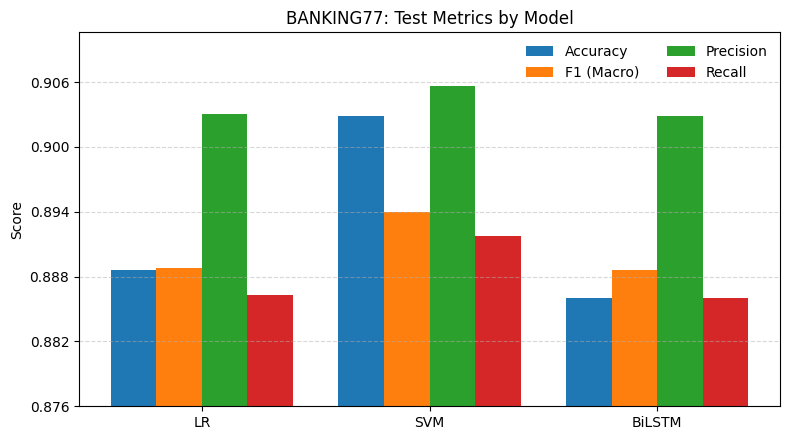

In [27]:
# Creating Test Metrics By Model Bar Plot

# Data from your table
models   = ["LR", "SVM", "BiLSTM"]
accuracy = [0.8886, 0.9029, 0.8860]
macro_f1 = [0.8888, 0.8940, 0.8886]
precision= [0.9030, 0.9056, 0.9029]
recall   = [0.8863, 0.8918, 0.8860]

# Grouped bar positions
x = np.arange(len(models))
w = 0.2  # bar width

# Y-axis zoom (show only useful range)
vals = accuracy + macro_f1 + precision + recall
ymin = max(0.0, min(vals) - 0.01)      # small padding below min
ymax = min(1.0, max(vals) + 0.005)     # small padding above max

plt.figure(figsize=(8, 4.5))
b1 = plt.bar(x - 1.5*w, accuracy,  width=w, label="Accuracy")
b2 = plt.bar(x - 0.5*w, macro_f1,  width=w, label="F1 (Macro)")
b3 = plt.bar(x + 0.5*w, precision, width=w, label="Precision")
b4 = plt.bar(x + 1.5*w, recall,    width=w, label="Recall")

# Labels, legend, grid
plt.xticks(x, models)
plt.ylabel("Score")
plt.title("BANKING77: Test Metrics by Model")
plt.ylim(ymin, ymax)
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.legend(ncol=2, frameon=False)
plt.gca().yaxis.set_major_locator(MaxNLocator(6))  # avoid crowded ticks
plt.tight_layout()
plt.savefig("test_metrics_by_model.png", dpi=300)
plt.show()
